# Modifications

- try the cnn input into the socat data

### Issues to fix
- socat pco2 -> -1 is continent, 0 is unmeasured value -> need to preprocess that


In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)


sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,plot_image

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2021-10-24 09:34:27.363557: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Reading Data
dir_name="../data/data1"
val_dir_name="../data/data2"

chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)



/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## Data Preprocessing

In [6]:
def convert_nan(arr):
    """
    convert_nan(arr)
    - converts nan values to the lowest value (continents)
    """
    nans=np.isnan(arr)
    min_val=arr[~nans].min()
    arr[nans]=min_val-1
    return arr

def add_dimension(arr):
    """
    add_dimension(arr)
    - add one dimension to axis=3
    """
    images=np.expand_dims(arr, axis=3)
    return images

def scale_image(arr):
    """
    scale_image(arr)
    - scales numerical values from scale 0-255 for like an image
    - have tried, regular normal/ min-max scaler -> does not work well
    """
    ## Normal
    #arr=(arr-np.mean(arr))/np.std(arr)
    
    ## Min-Max
    # min_val=arr.min()
    # max_val=arr.max()
    # arr=arr/(min_val-max_val)

    ## Image Scale
    min_pixel = arr.min() 
    max_pixel = arr.max()
    new_min = 0
    new_max = 255
    arr = (arr-min_pixel)*(255)/(max_pixel-min_pixel)+new_min 
    return arr
  

def preprocess_image_reduced(data,xco2=False):
  """
  preprocess_image_reduced(data,xco2=False)
  wrapper function for image preprocessing process
  dimension reduced the output should be  (180,360,5)
  """
  if xco2:
    return data
  return scale_image(convert_nan(data))

In [14]:
## XCO2 Handling
# - xco2 values are a constant value across the globe, 
# - creating an image layer with constant value for the model
# - xco2 layer improves prediction

xco2_images=[]
min_xco2=np.min(xco2.XCO2.data)
max_xco2=np.max(xco2.XCO2.data)
new_min=0
new_max=255
print(min_xco2, max_xco2)
print()


for i in xco2.XCO2.data:
    num = (i-min_xco2)*(new_max-new_min)/(max_xco2-min_xco2)+new_min
    tmp = (np.repeat(num,180*360)).reshape(180,-1)
    xco2_images.append(tmp)

xco2_images=np.array(xco2_images)

print("xco2 shape: ")
print(xco2_images.shape, chl.Chl.data.shape)

chl_images=preprocess_image_reduced(chl.Chl_socat.data)
mld_images=preprocess_image_reduced(mld.MLD_socat.data)
sss_images=preprocess_image_reduced(sss.SSS_socat.data)
sst_images=preprocess_image_reduced(sst.SST_socat.data)
xco2_images=preprocess_image_reduced(xco2_images,xco2=True)

# need to preprocess pco2_image otherwise, the prediction does not work well
pco2_images=preprocess_image_reduced(pco2.pCO2_socat.data)

# stacks image layer
X = np.stack((chl_images, mld_images, sss_images, sst_images,xco2_images), axis = 1)

340.84854 407.2084

xco2 shape: 
(421, 180, 360) (421, 180, 360)


In [15]:
# transform shapes to 421,180,360,5 | kernel = 5
X=X.reshape((421,180,360,5))
X.shape

(421, 180, 360, 5)

In [16]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

INPUT_SHAPE

(180, 360, 5)

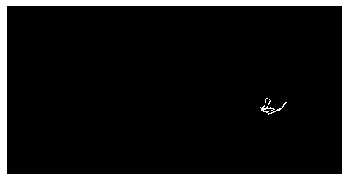

In [25]:
plot_image(pco2_images[420])

## Modeling

### Image Segmentation
CNN - Unet

Reference: 
https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47


In [31]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))

### Base Model

In [32]:
tf.keras.backend.clear_session()

In [33]:
from functools import partial

## Experiment 1
## relu vs. elu
## elu headstart & more training allowed

## Experiment 2
## kernel intializer = "he_normal" -> does not work
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu',
                        padding="SAME")


base_model = keras.models.Sequential([
    DefaultConv2D(filters=64, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3), #pool size 3 > pool size 2
    keras.layers.Dropout(0.3),# drop out at the end of the deepest

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),


    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),    
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])


## BEST SO FAR ##

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 180, 360, 128)     0

In [34]:
myLearnRate=0.001
custom_opt = tf.keras.optimizers.Adam(learning_rate=myLearnRate)
base_model.compile(loss=custom_rmse, optimizer=custom_opt, metrics=["mean_squared_error"])

In [35]:
model_path="../models/base_model/base_model_socat.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

#batch size 24, 32, 64 not as good
# batch size 16 the best
history = base_model.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=16,callbacks=callbacks)



Epoch 1/100
27/27 [==============================] - 8s 254ms/step - loss: 17.4584 - mean_squared_error: 203.5969 - val_loss: 15.5375 - val_mean_squared_error: 185.8123
Epoch 2/100
27/27 [==============================] - 6s 232ms/step - loss: 16.4103 - mean_squared_error: 172.6794 - val_loss: 15.5329 - val_mean_squared_error: 185.7169
Epoch 3/100
27/27 [==============================] - 6s 233ms/step - loss: 17.2030 - mean_squared_error: 189.0557 - val_loss: 15.5284 - val_mean_squared_error: 185.6244
Epoch 4/100
27/27 [==============================] - 6s 233ms/step - loss: 16.9398 - mean_squared_error: 183.0156 - val_loss: 15.5243 - val_mean_squared_error: 185.5388
Epoch 5/100
27/27 [==============================] - 6s 233ms/step - loss: 16.8140 - mean_squared_error: 181.1377 - val_loss: 15.5203 - val_mean_squared_error: 185.4583
Epoch 6/100
27/27 [==============================] - 6s 233ms/step - loss: 17.0258 - mean_squared_error: 186.8561 - val_loss: 15.5167 - val_mean_squared_er

KeyboardInterrupt: 

### Base Model Output

In [44]:

best_model = tf.keras.models.load_model('../models/base_model/base_model_socat.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X,verbose=1)

14/14 [==============================] - 3s 103ms/step


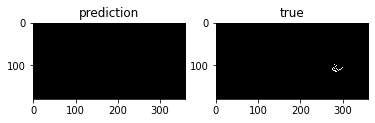

<Figure size 432x288 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


axis[0].imshow(np.squeeze(predicted_image[1]), cmap="gray", interpolation="nearest")
axis[0].set_title("prediction")
axis[1].imshow(np.squeeze(pco2_images[419:421][1]), cmap="gray", interpolation="nearest")
axis[1].set_title("true")

plt.show()
plt.savefig('base_model_prediction.png')

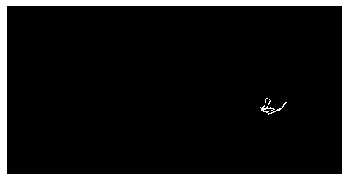

In [38]:
difference=np.squeeze(pco2_images[419:421][1])-np.squeeze(predicted_image[0])
plot_image(difference)

## Testing Generalization Capability

Using Validation data of other dataset

In [73]:
val_dir_name="../data/data2"

chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(val_dir_name)

In [74]:
xco2_images=[]
min_xco2=np.min(xco2.XCO2.data)
max_xco2=np.max(xco2.XCO2.data)
new_min=0
new_max=255
print(min_xco2, max_xco2)
print()


for i in xco2.XCO2.data:
    num = (i-min_xco2)*(new_max-new_min)/(max_xco2-min_xco2)+new_min
    tmp = (np.repeat(num,180*360)).reshape(180,-1)
    xco2_images.append(tmp)

xco2_images=np.array(xco2_images)

print("xco2 shape: ")
print(xco2_images.shape, chl.Chl.data.shape)


chl_images=preprocess_image_reduced(chl.Chl.data)
mld_images=preprocess_image_reduced(mld.MLD.data)
sss_images=preprocess_image_reduced(sss.SSS.data)
sst_images=preprocess_image_reduced(sst.SST.data)
xco2_images=preprocess_image_reduced(xco2_images,xco2=True)
pco2_images=preprocess_image_reduced(pco2.pCO2.data)

X = np.stack((chl_images, mld_images, sss_images, sst_images,xco2_images), axis = 1)

X=X.reshape((421,180,360,5))
X.shape


340.84854 407.2084

xco2 shape: 
(421, 180, 360) (421, 180, 360)


(421, 180, 360, 5)

In [75]:
predicted_image=best_model.predict(X,verbose=1)

14/14 [==============================] - 1s 45ms/step


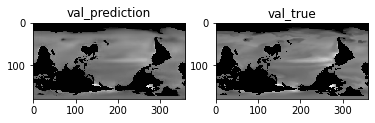

In [76]:
figure, axis = plt.subplots(1, 2)

axis[0].imshow(np.squeeze(predicted_image[0]), cmap="gray", interpolation="nearest")
axis[0].set_title("val_prediction")
axis[1].imshow(np.squeeze(pco2_images[0]), cmap="gray", interpolation="nearest")
axis[1].set_title("val_true")

plt.show()

In [79]:
print("RMSE score!")
np.sqrt(np.mean((predicted_image[1]-pco2_images[1])**2))

RMSE score!


7.15476599956448

In [ ]:
# generalization works pretty well

## Getting PCO2 Prediction per Point

In [45]:
def inverse_scale_image(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    old_min = np.min(df)
    old_max = np.max(df)
    output = arr*(old_max-old_min)/255 + old_min
    return output

def get_point_prediction(pred,lon,lan):
    pco2_value = pred[lan][lon]
    return pco2_value
    

In [46]:
actual=inverse_scale_image(predicted_image,pco2.pCO2_socat.data)  

In [47]:
print(get_point_prediction(actual[0],100,100))

print(get_point_prediction(pco2.pCO2_socat.data[0],100,100))

3.0843697
0.0


In [48]:
print("Scaled back RMSE score:")
np.sqrt(np.mean((pco2.pCO2_socat.data-actual)**2))

Scaled back RMSE score:


33.92481359083977

In [50]:
#pco2 data information
print("mean:",np.mean(pco2.pCO2_socat.data))
print("min:",np.min(pco2.pCO2_socat.data))
print("max:",np.max(pco2.pCO2_socat.data))
print("std:",np.std(pco2.pCO2_socat.data))

mean: 2.8395542252779515
min: -1.0
max: 635.2041036748
std: 33.92393024013906


In [70]:
tmp=pco2.pCO2_socat.data[1]
print(180*360)
print(len(tmp[tmp==-1]))
print(len(tmp[tmp==0]))



print("non-negative")
non_neg=tmp[tmp!=-1]
print("mean:",np.mean(non_neg))
print("min:",np.min(non_neg))
print("max:",np.max(non_neg))
print("std:",np.std(non_neg))




64800
23730
40953
non-negative
mean: 0.889612680573204
min: 0.0
max: 360.2164984908082
std: 16.708820443960864


In [64]:
tmp=pco2.pCO2_socat.data[0]

